In [ ]:
!pip install scikit-survival

     |████████████████████████████████| 2.5 MB 13.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-survival: filename=scikit_survival-0.17.0-cp37-cp37m-linux_x86_64.whl size=4080348 sha256=a35fb316e6013f8589d5f20b70ddc48e55fc97545c89434014a30c5019e00afa
  Stored in directory: /root/.cache/pip/wheels/91/c1/99/2c2faacc82ff4f89d27612b1fd905ea35aa24f6a93dd4dcc0d
Successfully built scikit-survival


In [ ]:
!pip install eli5

     |████████████████████████████████| 106 kB 16.0 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 
import time
from datetime import timedelta
import math
import pickle
import copy
import seaborn as sns
from numpy import sqrt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

plt.rcParams['axes.unicode_minus'] = False 

pd.options.display.float_format = '{:.5f}'.format

import warnings 
warnings.filterwarnings(action='ignore')
pd.options.display.float_format = '{:.5f}'.format

from sklearn.pipeline import make_pipeline
import eli5
from eli5.sklearn import PermutationImportance

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pkg_resources

dists = [d for d in pkg_resources.working_set]
# Filter out distributions you don't care about and use.
dists

[zipp 3.7.0 (/usr/local/lib/python3.7/dist-packages),
 zict 2.0.0 (/usr/local/lib/python3.7/dist-packages),
 yellowbrick 1.3.post1 (/usr/local/lib/python3.7/dist-packages),
 xlwt 1.3.0 (/usr/local/lib/python3.7/dist-packages),
 xlrd 1.1.0 (/usr/local/lib/python3.7/dist-packages),
 xgboost 0.90 (/usr/local/lib/python3.7/dist-packages),
 xarray 0.18.2 (/usr/local/lib/python3.7/dist-packages),
 wrapt 1.13.3 (/usr/local/lib/python3.7/dist-packages),
 wordcloud 1.5.0 (/usr/local/lib/python3.7/dist-packages),
 widgetsnbextension 3.5.2 (/usr/local/lib/python3.7/dist-packages),
 wheel 0.37.1 (/usr/local/lib/python3.7/dist-packages),
 Werkzeug 1.0.1 (/usr/local/lib/python3.7/dist-packages),
 webencodings 0.5.1 (/usr/local/lib/python3.7/dist-packages),
 wcwidth 0.2.5 (/usr/local/lib/python3.7/dist-packages),
 wasabi 0.9.0 (/usr/local/lib/python3.7/dist-packages),
 vega-datasets 0.9.0 (/usr/local/lib/python3.7/dist-packages),
 urllib3 1.24.3 (/usr/local/lib/python3.7/dist-packages),
 uritemplate 

In [ ]:
data1 = pd.read_excel('/content/gdrive/MyDrive/FactoryHack2022/Final/data/1.One Hot Encoding.xlsx')
data2 = pd.read_excel('/content/gdrive/MyDrive/FactoryHack2022/Final/data/2.Stepwise Full.xlsx')
data3 = pd.read_excel('/content/gdrive/MyDrive/FactoryHack2022/Final/data/3.Stepwise Seperate.xlsx')
data4 = pd.read_excel('/content/gdrive/MyDrive/FactoryHack2022/Final/data/4.RFECV Full.xlsx')
data5 = pd.read_excel('/content/gdrive/MyDrive/FactoryHack2022/Final/data/5.RFECV Seperate.xlsx')
data6 = pd.read_excel('/content/gdrive/MyDrive/FactoryHack2022/Final/data/6.Correlation.xlsx')
data7 = pd.read_excel('/content/gdrive/MyDrive/FactoryHack2022/Final/data/7.Autoencoder.xlsx')

# Modeling

In [ ]:
class reciprocal_int:
    def __init__(self, a, b):
        self._distribution = reciprocal(a, b)

    def rvs(self, *args, **kwargs):
        return self._distribution.rvs(*args, **kwargs).astype(int)

param_distributions1 = {
    'randomsurvivalforest__max_features': reciprocal_int(3, 8),
    'randomsurvivalforest__max_depth': reciprocal_int(5, 50),
    'randomsurvivalforest__min_samples_leaf': reciprocal_int(1, 40),
}

In [ ]:
data1

,Lot No.,1-수소공급량,2-수소공급량,1-산소공급량,2-산소공급량,1-버너회전수,2-버너회전수,1-버너속도,2-버너속도,1-핀치횟수,2-핀치횟수,핀치두께-상,핀치두께-중,핀치두께-하,핀치두께2-상,핀치두께2-중,핀치두께2-하,전극간격,채널,전압(1차),전류(1차),역률(1차),전력(1차),온도(1차),전압(2차),전류(2차),역률(2차),전력(2차),온도(2차),강도,lamp_ver_21,lamp_ver_22,lamp_ver_24,lamp_ver_25,lamp_ver_26,lamp_ver_27,lamp_ver_28,lamp_ver_33,lamp_ver_34,lamp_ver_35,lamp_ver_36,lamp_ver_37,lamp_ver_39,lamp_ver_40,lamp_ver_41,lamp_ver_42,lamp_ver_43,lamp_ver_44,lamp_ver_45,lamp_ver_46,lamp_ver_47,lamp_ver_48,lamp_ver_49,lamp_ver_50,lamp_ver_52,lamp_ver_53,lamp_ver_54,lamp_ver_57,lamp_ver_58,lamp_ver_59,lamp_ver_60,lamp_ver_61,lamp_ver_62,lamp_ver_63,lamp_ver_64,lamp_ver_65,lamp_ver_66,lamp_ver_67,lamp_ver_68,lamp_ver_69,y_cum_time,event
0,GV4KI7P051,-0.66667,-0.50000,0.85000,0.66667,1.40000,1.00000,0.50000,0.80000,0.52479,0.52483,0.86667,0.11111,0.57143,0.83333,0.31579,0.58824,0.46535,-0.66667,-2.35744,1.46377,1.26087,0.40000,-0.90000,-0.12623,-0.93333,1.09091,-0.00028,0.93651,1.90476,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,858.57000,0
1,GV4KI7P052,-0.66667,-0.50000,0.85000,0.66667,1.40000,1.00000,0.50000,0.80000,0.52523,0.52528,0.93333,0.33333,0.71429,0.16667,0.00000,0.17647,0.11881,-0.33333,-2.35744,1.46377,1.26087,0.40000,-0.90000,1.22781,-1.66667,0.90909,0.00000,0.93651,2.46032,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,858.57000,0
2,GV4KI7Q099,-0.66667,-0.50000,0.85000,0.66667,1.40000,1.00000,0.50000,0.80000,0.58553,0.58568,1.26667,0.66667,0.85714,0.16667,0.26316,-0.05882,-2.33663,-0.66667,-0.71694,0.75362,1.08696,0.80000,-0.90000,0.55621,-0.60000,0.81818,0.00005,1.04762,2.14286,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,858.57000,0
3,GV4KI7Q100,-0.66667,-0.50000,0.85000,0.66667,1.40000,1.00000,0.50000,0.80000,0.58598,0.58613,1.33333,0.50000,0.85714,0.05556,0.26316,-0.05882,0.29703,-0.33333,-0.71694,0.75362,1.08696,0.80000,-0.90000,0.92505,-1.33333,0.50000,-0.00005,1.04762,2.38095,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,858.57000,0
4,GV4KI8A058,-0.66667,-0.50000,0.85000,0.66667,1.40000,1.00000,0.50000,0.80000,-0.62796,-0.62908,1.20000,0.88889,1.07143,0.66667,1.00000,0.64706,-0.33663,0.66667,-1.71074,0.72464,0.56522,-0.20000,-0.80000,-0.01479,-0.26667,0.81818,-0.00014,0.90476,2.26984,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,838.28000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,GN4KL3V145,-0.83333,-0.83333,-0.15000,-0.33333,0.00000,0.00000,-0.50000,0.00000,0.77535,0.77718,1.06667,-8.38889,1.28571,-0.88889,-8.31579,-0.52941,-0.85149,0.00000,1.14463,-0.75362,0.00000,0.14286,0.40000,-0.04635,-0.40000,-1.27273,-0.00023,0.00000,0.39683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,956.02000,1
296,GN4KL3V156,-0.83333,-0.83333,-0.15000,-0.33333,0.00000,0.00000,-0.50000,0.00000,0.78026,0.78210,1.00000,-8.88889,1.21429,-0.77778,-8.47368,-0.47059,-0.90099,0.66667,0.24587,-0.73913,-0.17391,-0.62857,0.30000,-0.63807,0.13333,0.09091,-0.00028,0.00000,-0.68254,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,946.02000,1
297,GN4KL3V157,-0.83333,-0.83333,-0.15000,-0.33333,0.00000,0.00000,-0.50000,0.00000,0.78071,0.78255,0.86667,-9.33333,1.00000,-0.88889,-9.15789,-0.58824,-1.36634,1.00000,0.24587,-0.73913,-0.17391,-0.62857,0.30000,-0.14990,0.26667,0.18182,-0.00009,0.00000,-0.34921,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,520.35000,1
298,GN4KL3V153,-0.83333,-0.83333,-0.15000,-0.33333,0.00000,0.00000,-0.50000,0.00000,0.77892,0.78076,0.93333,-7.88889,1.14286,-0.72222,-8.84211,-0.35294,-0.85149,-0.33333,0.24587,-0.73913,-0.17391,-0.62857,0.300

In [ ]:
y = ['y_cum_time', 'event','Lot No.']

### Data 7개에 대해서 모델 각각 학습하여 이 모델과 잘 맞는 데이터 선택

In [ ]:
score = []

In [ ]:
score = []
#data 바꿔가면서 모델 학습
for i in range(7):
    X = globals()['data{}'.format(i+1)].drop(y,axis = 1)
    Y = pd.DataFrame(columns = ['obs', 'value'])
    Y['obs'] = globals()['data{}'.format(i+1)].apply(lambda x: True if x['event'] == 1 else False, axis = 1)
    Y['value'] = globals()['data{}'.format(i+1)]['y_cum_time']
    y_new = np.empty(dtype=[('obs', bool), ('value', np.float64)], shape = Y.shape[0])
    y_new['obs'] = (Y['obs'] == True).values
    y_new['value'] = Y['value'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y_new, test_size=0.3, random_state=30)

    globals()['rsf{}'.format(i+1)] = make_pipeline(RandomSurvivalForest(random_state=610))
    globals()['rsf{}'.format(i+1)].fit(X_train, y_train)

    param_distributions1 = {
        'randomsurvivalforest__max_features': reciprocal_int(3, 8),
        'randomsurvivalforest__max_depth': reciprocal_int(5, 50),
        'randomsurvivalforest__min_samples_leaf': reciprocal_int(1, 40),
    }

    model_random_search = RandomizedSearchCV(globals()['rsf{}'.format(i+1)], param_distributions=param_distributions1, n_iter=50, n_jobs=-1, cv=3, random_state=610)
    model_random_search.fit(X_train, y_train)
    print("< data"+str(i+1)+" >")
    print(
        f"The c-index of random survival forest using a {model_random_search.__class__.__name__} is "
        f"{model_random_search.score(X_test, y_test):.3f}")
    print(
        f"The best set of parameters is: {model_random_search.best_params_}"
    )

    max_depth = model_random_search.best_params_['randomsurvivalforest__max_depth']
    max_features = model_random_search.best_params_['randomsurvivalforest__max_features']
    min_samples_leaf = model_random_search.best_params_['randomsurvivalforest__min_samples_leaf']

    globals()['rsf_best{}'.format(i+1)] = RandomSurvivalForest(random_state=610, max_depth=max_depth, max_features=max_features, min_samples_leaf=min_samples_leaf)
    globals()['rsf_best{}'.format(i+1)].fit(X_train, y_train)
    score.append(globals()['rsf_best{}'.format(i+1)].score(X_test, y_test))
    globals()['rsf_best{}'.format(i+1)].score(X_test, y_test)

< data1 >
The c-index of random survival forest using a RandomizedSearchCV is 0.592
The best set of parameters is: {'randomsurvivalforest__max_depth': 30, 'randomsurvivalforest__max_features': 7, 'randomsurvivalforest__min_samples_leaf': 8}
< data2 >
The c-index of random survival forest using a RandomizedSearchCV is 0.590
The best set of parameters is: {'randomsurvivalforest__max_depth': 10, 'randomsurvivalforest__max_features': 3, 'randomsurvivalforest__min_samples_leaf': 2}
< data3 >
The c-index of random survival forest using a RandomizedSearchCV is 0.584
The best set of parameters is: {'randomsurvivalforest__max_depth': 14, 'randomsurvivalforest__max_features': 3, 'randomsurvivalforest__min_samples_leaf': 14}
< data4 >
The c-index of random survival forest using a RandomizedSearchCV is 0.579
The best set of parameters is: {'randomsurvivalforest__max_depth': 25, 'randomsurvivalforest__max_features': 4, 'randomsurvivalforest__min_samples_leaf': 8}
< data5 >
The c-index of random sur

In [ ]:
score

[0.591745177209511,
 0.5901749663526245,
 0.591745177209511,
 0.5901749663526245,
 0.5838941229250785,
 0.5787348586810229,
 0.5989232839838493,
 0.5953342305966801,
 0.6996410946612831]

# Model 선택

- Random Survival Forest는 data7 을 사용하기로 함

In [ ]:
i = 6
X = globals()['data{}'.format(i+1)].drop(y,axis = 1)
Y = pd.DataFrame(columns = ['obs', 'value'])
Y['obs'] = globals()['data{}'.format(i+1)].apply(lambda x: True if x['event'] == 1 else False, axis = 1)
Y['value'] = globals()['data{}'.format(i+1)]['y_cum_time']
y_new = np.empty(dtype=[('obs', bool), ('value', np.float64)], shape = Y.shape[0])
y_new['obs'] = (Y['obs'] == True).values
y_new['value'] = Y['value'].values

X_train, X_test, y_train, y_test = train_test_split(X, y_new, test_size=0.3, random_state=30)

globals()['rsf{}'.format(i+1)] = make_pipeline(RandomSurvivalForest(random_state=610))
globals()['rsf{}'.format(i+1)].fit(X_train, y_train)

param_distributions1 = {
    'randomsurvivalforest__max_features': reciprocal_int(3, 8),
    'randomsurvivalforest__max_depth': reciprocal_int(5, 50),
    'randomsurvivalforest__min_samples_leaf': reciprocal_int(1, 40),
}

model_random_search = RandomizedSearchCV(globals()['rsf{}'.format(i+1)], param_distributions=param_distributions1, n_iter=50, n_jobs=-1, cv=3, random_state=610)
model_random_search.fit(X_train, y_train)
print("< data"+str(i+1)+" >")
print(
    f"The c-index of random survival forest using a {model_random_search.__class__.__name__} is "
    f"{model_random_search.score(X_test, y_test):.3f}")
print(
    f"The best set of parameters is: {model_random_search.best_params_}"
)

max_depth = model_random_search.best_params_['randomsurvivalforest__max_depth']
max_features = model_random_search.best_params_['randomsurvivalforest__max_features']
min_samples_leaf = model_random_search.best_params_['randomsurvivalforest__min_samples_leaf']

globals()['rsf_best{}'.format(i+1)] = RandomSurvivalForest(random_state=610, max_depth=max_depth, max_features=max_features, min_samples_leaf=min_samples_leaf)
globals()['rsf_best{}'.format(i+1)].fit(X_train, y_train)
score.append(globals()['rsf_best{}'.format(i+1)].score(X_test, y_test))
globals()['rsf_best{}'.format(i+1)].score(X_test, y_test)

< data7 >
The c-index of random survival forest using a RandomizedSearchCV is 0.700
The best set of parameters is: {'randomsurvivalforest__max_depth': 7, 'randomsurvivalforest__max_features': 5, 'randomsurvivalforest__min_samples_leaf': 17}


0.6996410946612831

- Autoencoder를 이용하여 Feauture extraction을 했기 때문에 각각의 변수가 의미하는 바는 알 수 없음(단점)

In [ ]:
perm = PermutationImportance(rsf_best7, n_iter=15, random_state=610)
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X.columns.tolist())

Weight,Feature
0.0672 ± 0.0513,feature_7
0.0218 ± 0.0244,feature_6
0.0170 ± 0.0416,feature_1
0.0042 ± 0.0166,feature_5
0 ± 0.0000,feature_9
0 ± 0.0000,feature_8
0 ± 0.0000,feature_3
0 ± 0.0000,feature_0
-0.0000 ± 0.0007,feature_4
-0.0049 ± 0.0124,feature_2


In [ ]:
result = pd.DataFrame()
column_name = []
for i in range(0,len(X_test)):
    column_name.append(y_test[i][1])
    result[i] = rsf_best7.predict_survival_function(X_test)[i].y
result.index = rsf_best7.predict_survival_function(X_test)[0].x
result.columns = column_name
result

,476.28000,535.42000,1192.42000,682.50000,276.10000,427.15000,1023.33000,3695.63000,295.77000,344.10000,641.07000,656.83000,2939.93000,976.62000,885.27000,170.10000,535.92000,352.58000,858.57000,893.30000,398.73000,609.07000,3015.00000,150.08000,649.70000,520.35000,476.00000,5659.35000,553.23000,2574.20000,364.42000,393.85000,858.57000,1199.07000,606.12000,441.95000,412.10000,476.00000,132.00000,989.72000,...,3902.70000,142.18000,408.10000,774.50000,900.57000,1041.85000,916.13000,2835.37000,1039.47000,799.42000,665.78000,2574.20000,574.92000,535.42000,907.92000,278.10000,654.08000,948.45000,221.37000,448.12000,488.35000,327.20000,325.25000,729.50000,2499.42000,3767.07000,402.85000,492.47000,574.28000,1017.25000,81.85000,1015.33000,867.70000,1148.42000,632.63000,1124.35000,437.85000,636.43000,182.28000,371.92000
22.13000,0.99966,0.99892,1.00000,1.00000,0.98729,1.00000,1.00000,1.00000,0.99627,0.99718,1.00000,0.97843,1.00000,1.00000,1.00000,0.97117,1.00000,0.98772,1.00000,1.00000,0.99525,0.99955,1.00000,1.00000,1.00000,1.00000,0.99379,1.00000,0.99688,1.00000,0.99299,1.00000,1.00000,1.00000,1.00000,0.97117,1.00000,1.00000,0.99595,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0.97346,1.00000,1.00000,1.00000,0.99960,1.00000,1.00000,0.99798,1.00000,0.99668,1.00000,0.97117,0.97622,0.99941,0.99967,1.00000,1.00000,1.00000,1.00000,1.00000,0.99938,1.00000,0.99724,1.00000,0.99967,1.00000,1.00000,0.99926,1.00000,1.00000,0.99926,1.00000,0.98888,0.99813
101.63000,0.99136,0.99487,0.99340,0.98885,0.98729,0.99114,0.99977,0.99977,0.99312,0.99447,0.99977,0.97843,0.99977,0.99977,0.99413,0.97117,0.99977,0.98705,0.99916,0.99271,0.99310,0.99599,0.99977,0.99900,0.98394,0.99737,0.99200,0.99977,0.99514,0.99977,0.99120,0.98755,0.98933,0.98607,0.99271,0.97117,0.99719,0.98720,0.99190,0.99977,...,0.99977,0.99738,0.99775,0.99461,0.99215,0.99977,0.97346,0.99977,0.99929,0.98932,0.99555,0.99977,0.99388,0.99343,0.99977,0.99355,0.98999,0.97117,0.97592,0.99478,0.99512,0.98845,0.99670,0.99569,0.99977,0.99977,0.99619,0.99593,0.99483,0.99977,0.99512,0.99977,0.99977,0.99385,0.99123,0.99977,0.99385,0.98562,0.98858,0.99491
150.08000,0.97097,0.97876,0.99046,0.98463,0.98729,0.97817,0.99954,0.99954,0.98064,0.99018,0.99954,0.97763,0.99954,0.99954,0.98720,0.97037,0.99954,0.98665,0.99861,0.98895,0.98321,0.98692,0.99954,0.99723,0.97133,0.99494,0.98173,0.99954,0.99383,0.99954,0.98050,0.98118,0.97421,0.97627,0.98895,0.97037,0.99460,0.97013,0.97627,0.99954,...,0.99954,0.99344,0.99276,0.99314,0.98796,0.99904,0.97266,0.99954,0.99906,0.98433,0.98088,0.99954,0.99130,0.97637,0.99954,0.98067,0.98348,0.97037,0.97592,0.99105,0.98029,0.96831,0.99188,0.99296,0.99954,0.99954,0.99445,0.99077,0.99305,0.99954,0.98010,0.99954,0.99954,0.97685,0.98796,0.99954,0.97786,0.97703,0.98858,0.98099
153.70000,0.97058,0.97837,0.99046,0.98463,0.97046,0.97817,0.99954,0.99954,0.97630,0.98574,0.99954,0.95357,0.99954,0.99954,0.98720,0.93920,0.99954,0.97403,0.99861,0.98895,0.97690,0.98550,0.99954,0.99723,0.97133,0.99494,0.97392,0.99954,0.98935,0.99954,0.97246,0.98118,0.97421,0.97627,0.98895,0.94090,0.99352,0.97013,0.97262,0.99954,...,0.99954,0.99344,0.99276,0.99314,0.98796,0.99904,0.94217,0.99954,0.99906,0.98433,0.98021,0.99954,0.99130,0.97494,0.99954,0.97558,0.98348,0.94024,0.95207,0.99105,0.98029,0.96831,0.99154,0.99296,0.99954,0.99954,0.99307,0.99077,0.98948,0.99954,0.98010,0.99954,0.99954,0.97580,0.98796,0.99954,0.97747,0.97703,0.97504,0.97838
170.28000,0.97018,0.97713,0.99046,0.98463,0.95500,0.97817,0.99954,0.99954,0.97095,0.98284,0.99954,0.92989,0.99954,0.99954,0.98720,0.91427,0.99954,0.96586,0.99861,0.98895,0.96917,0.98422,0.99954,0.99723,0.97133,0.99494,0.96579,0.99954,0.98387,0.99954,0.96382,0.98118,0.97421,0.97627,0.98895,0.91640,0.99275,0.97013,0.96896,0.99954,...,0.99954,0.99344,0.99276,0.99314,0.98796,0.99904,0.91559,0.99954,0.99906,0.98433,0.97973,0.99954,0.99130,0.97256,0.99954,0.97026,0.98348,0.91573,0.93221,0.99105,0.97993,0.96831,0.99120,0.99296,0.99954,0.99954,0.99115,0.99077,0.98

In [ ]:
pred = []
real = []
check = []
for j in range(len(result.columns)):
    real.append(y_test[j][1])
    check.append(y_test[j][0])
    for i in range(len(result)):
        if result.iloc[len(result)-1, j] >= 0.5:
            pred.append(result.index[len(result)-1])
            break
            
        elif result.iloc[i,j] < 0.5:
            #print(result.iloc[i-1:i+1,j])
            a = result.iloc[i-1,j] - 0.5
            b = 0.5 - result.iloc[i,j] 
            v = (a*result.index[i]+b*result.index[i-1])/(a+b)
            #print(pred)
            pred.append(v)
            break

prediction = pd.DataFrame()
prediction['pred'] = pred
prediction['real'] = real
prediction['gas_leak'] = check
prediction

,pred,real,gas_leak
0,636.46945,476.28000,True
1,709.73156,535.42000,False
2,628.87458,1192.42000,False
3,620.54559,682.50000,False
4,457.05718,276.10000,True
...,...,...,...
85,1669.63296,1124.35000,False
86,625.95751,437.85000,True
87,614.79663,636.43000,False
88,468.99972,182.28000,True


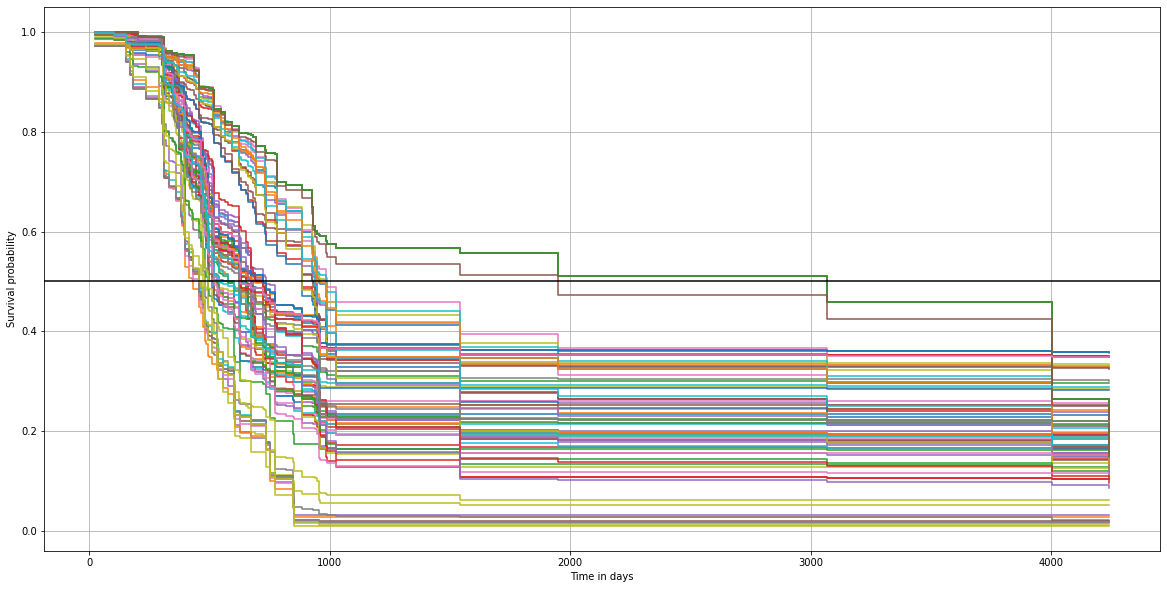

In [ ]:
surv = rsf_best7.predict_survival_function(X_test, return_array=True)
plt.figure(figsize=(20,10))
for i, s in enumerate(surv):
    plt.step(rsf_best7.event_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.axhline(y=0.5, color='black', linewidth=1.5)
#plt.legend()
plt.grid(True)

-  전체 데이터  
x: predict, y: real

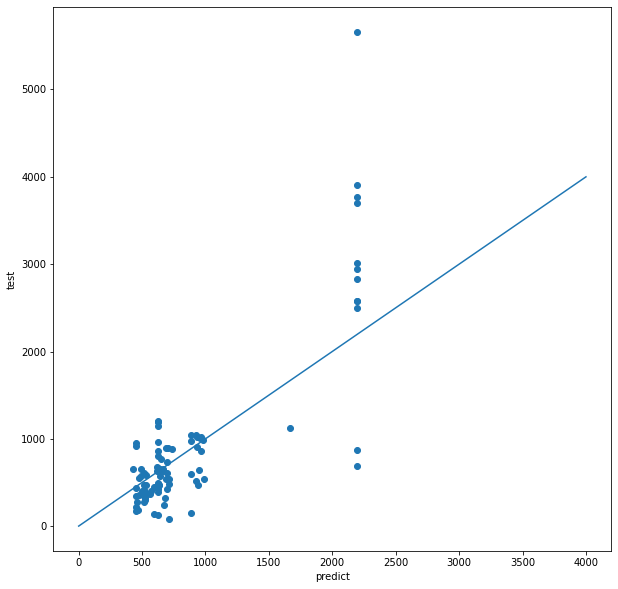

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(prediction['pred'], prediction['real'])
plt.plot([1,100,1000,4000],[1,100,1000,4000])
plt.xlabel("predict")
plt.ylabel("test")
plt.show()

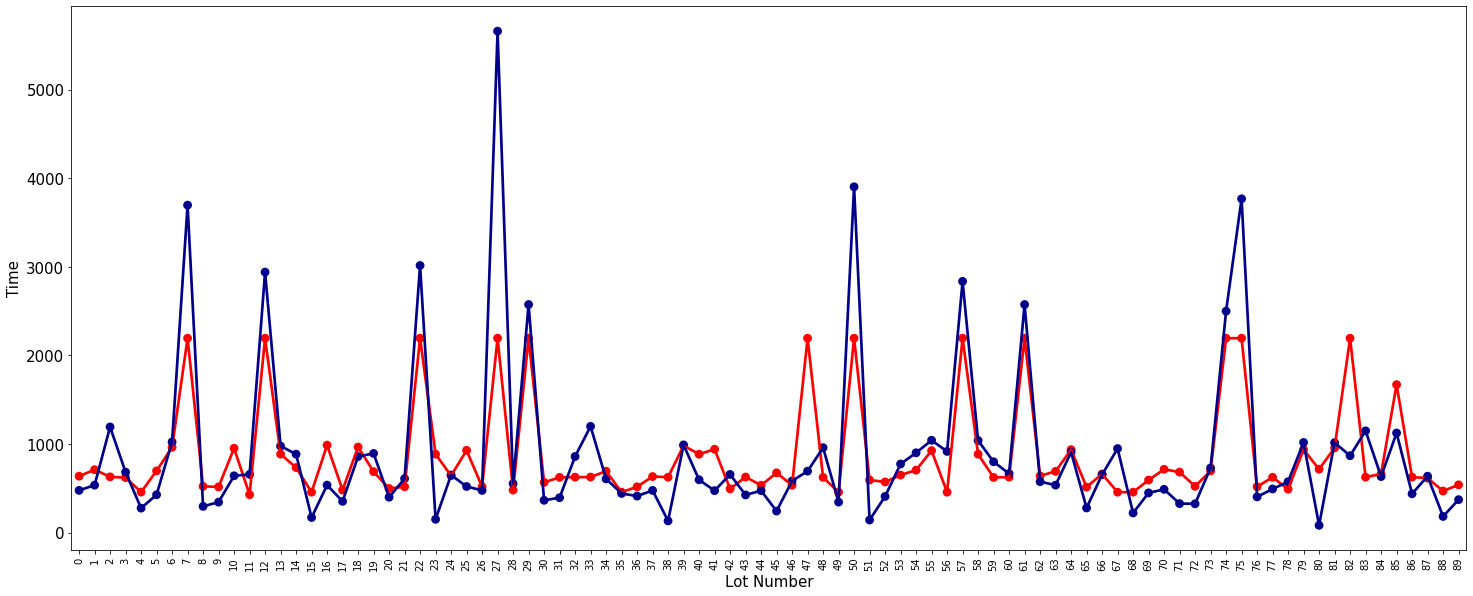

In [ ]:
plt.figure(figsize=(25,10))
sns.pointplot(x = 'index', y='pred', data=prediction.reset_index(), color='Red', label='y_pred')
sns.pointplot(x = 'index', y='real', data=prediction.reset_index(), color='DarkBlue', label='y_test')

plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=15)
plt.xlabel("Lot Number", fontsize=15)
plt.ylabel("Time", fontsize=15)
plt.show()

-  gas leak 데이터  
x: predict, y: real

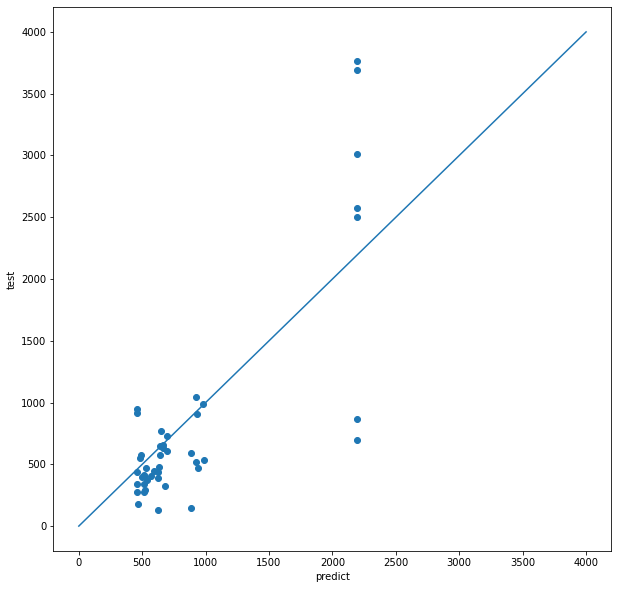

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(prediction[prediction['gas_leak']==1]['pred'], prediction[prediction['gas_leak']==1]['real'])
plt.plot([1,100,1000,4000],[1,100,1000,4000])
plt.xlabel("predict")
plt.ylabel("test")
plt.show()

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


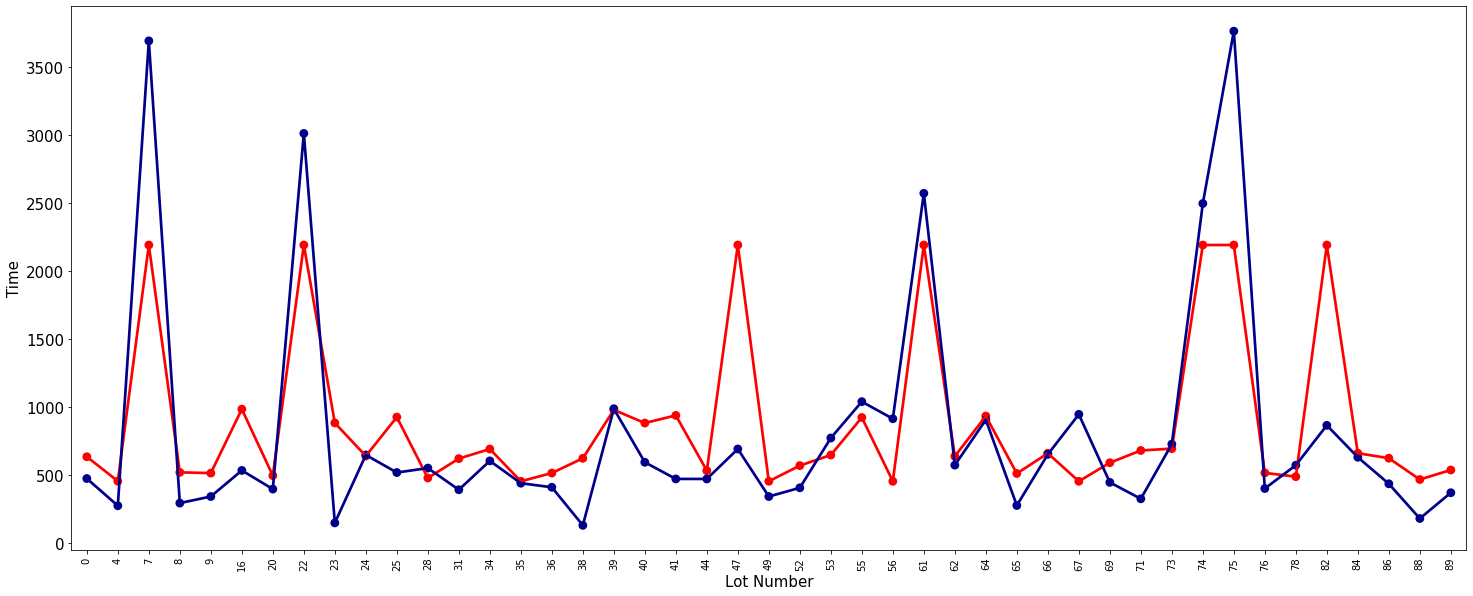

In [ ]:
plt.figure(figsize=(25,10))
sns.pointplot(x = 'index', y='pred', data=prediction[prediction['gas_leak']==1].reset_index(), color='Red', label='y_pred')
sns.pointplot(x = 'index', y='real', data=prediction[prediction['gas_leak']==1].reset_index(), color='DarkBlue', label='y_test')

plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=15)
plt.xlabel("Lot Number", fontsize=15)
plt.ylabel("Time", fontsize=15)
plt.show()

## Feature Importance 확인   
- 두번째로 좋은 성능을 보인 data5 이용

In [ ]:
i = 4
X = globals()['data{}'.format(i+1)].drop(y,axis = 1)
Y = pd.DataFrame(columns = ['obs', 'value'])
Y['obs'] = globals()['data{}'.format(i+1)].apply(lambda x: True if x['event'] == 1 else False, axis = 1)
Y['value'] = globals()['data{}'.format(i+1)]['y_cum_time']
y_new = np.empty(dtype=[('obs', bool), ('value', np.float64)], shape = Y.shape[0])
y_new['obs'] = (Y['obs'] == True).values
y_new['value'] = Y['value'].values

X_train, X_test, y_train, y_test = train_test_split(X, y_new, test_size=0.3, random_state=30)

globals()['rsf{}'.format(i+1)] = make_pipeline(RandomSurvivalForest(random_state=610))
globals()['rsf{}'.format(i+1)].fit(X_train, y_train)

param_distributions1 = {
    'randomsurvivalforest__max_features': reciprocal_int(3, 8),
    'randomsurvivalforest__max_depth': reciprocal_int(5, 50),
    'randomsurvivalforest__min_samples_leaf': reciprocal_int(1, 40),
}

model_random_search = RandomizedSearchCV(globals()['rsf{}'.format(i+1)], param_distributions=param_distributions1, n_iter=50, n_jobs=-1, cv=3, random_state=610)
model_random_search.fit(X_train, y_train)
print("< data"+str(i+1)+" >")
print(
    f"The c-index of random survival forest using a {model_random_search.__class__.__name__} is "
    f"{model_random_search.score(X_test, y_test):.3f}")
print(
    f"The best set of parameters is: {model_random_search.best_params_}"
)

max_depth = model_random_search.best_params_['randomsurvivalforest__max_depth']
max_features = model_random_search.best_params_['randomsurvivalforest__max_features']
min_samples_leaf = model_random_search.best_params_['randomsurvivalforest__min_samples_leaf']

globals()['rsf_best{}'.format(i+1)] = RandomSurvivalForest(random_state=610, max_depth=max_depth, max_features=max_features, min_samples_leaf=min_samples_leaf)
globals()['rsf_best{}'.format(i+1)].fit(X_train, y_train)
score.append(globals()['rsf_best{}'.format(i+1)].score(X_test, y_test))
globals()['rsf_best{}'.format(i+1)].score(X_test, y_test)

< data5 >
The c-index of random survival forest using a RandomizedSearchCV is 0.599
The best set of parameters is: {'randomsurvivalforest__max_depth': 17, 'randomsurvivalforest__max_features': 3, 'randomsurvivalforest__min_samples_leaf': 6}


0.5989232839838493

In [ ]:
perm = PermutationImportance(rsf_best5, n_iter=15, random_state=610)
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X.columns.tolist())

Weight,Feature
0.0211 ± 0.0263,1-산소공급량
0.0156 ± 0.0337,강도
0.0093 ± 0.0185,2-버너속도
0.0069 ± 0.0391,핀치두께2-하
0.0054 ± 0.0141,2-버너회전수
0.0044 ± 0.0118,1-버너회전수
0.0020 ± 0.0175,전압(1차)
0.0010 ± 0.0015,lamp_ver_59
0 ± 0.0000,lamp_ver_42
-0.0002 ± 0.0014,lamp_ver_40


In [85]:
data5

,Lot No.,2-수소공급량,1-산소공급량,1-버너회전수,2-버너회전수,2-버너속도,핀치두께2-하,전압(1차),전압(2차),전력(2차),온도(2차),강도,lamp_ver_40,lamp_ver_42,lamp_ver_59,y_cum_time,event
0,GV4KI7P051,-0.50000,0.85000,1.40000,1.00000,0.80000,0.58824,-2.35744,-0.12623,-0.00028,0.93651,1.90476,0,0,0,858.57000,0
1,GV4KI7P052,-0.50000,0.85000,1.40000,1.00000,0.80000,0.17647,-2.35744,1.22781,0.00000,0.93651,2.46032,0,0,0,858.57000,0
2,GV4KI7Q099,-0.50000,0.85000,1.40000,1.00000,0.80000,-0.05882,-0.71694,0.55621,0.00005,1.04762,2.14286,0,0,0,858.57000,0
3,GV4KI7Q100,-0.50000,0.85000,1.40000,1.00000,0.80000,-0.05882,-0.71694,0.92505,-0.00005,1.04762,2.38095,0,0,0,858.57000,0
4,GV4KI8A058,-0.50000,0.85000,1.40000,1.00000,0.80000,0.64706,-1.71074,-0.01479,-0.00014,0.90476,2.26984,0,0,0,838.28000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,GN4KL3V145,-0.83333,-0.15000,0.00000,0.00000,0.00000,-0.52941,1.14463,-0.04635,-0.00023,0.00000,0.39683,0,0,0,956.02000,1
296,GN4KL3V156,-0.83333,-0.15000,0.00000,0.00000,0.00000,-0.47059,0.24587,-0.63807,-0.00028,0.00000,-0.68254,0,0,0,946.02000,1
297,GN4KL3V157,-0.83333,-0.15000,0.00000,0.00000,0.00000,-0.58824,0.24587,-0.14990,-0.00009,0.00000,-0.34921,0,0,0,520.35000,1
298,GN4KL3V153,-0.83333,-0.15000,0.00000,0.00000,0.00000,-0.35294,0.24587,-0.07988,-0.00037,0.00000,-0.69841,0,0,0,234.13000,1
